## Imports

In [1]:
from pathlib import Path, PosixPath
from typing import List
import torch
import torch.nn.functional as F
from torch import Tensor
from langchain.docstore.document import Document
from langchain_community.document_loaders import TextLoader

import pickle
import random
from typing import List

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.embeddings import Embeddings
from langchain.retrievers import BM25Retriever, EnsembleRetriever
from langchain_core.runnables import ConfigurableField
from langchain_community.vectorstores.utils import DistanceStrategy


from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS

from transformers import AutoTokenizer, AutoModel

from sentence_transformers import CrossEncoder

/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
2024-08-05 15:14:46.927193: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-05 15:14:48.462196: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-05 15:14:53.275699: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Chunking and Tokenizer

- Проходим циклом по `codex`, `federal_laws`
- Читаем документы через `TextLoader`
- Разбиваем `RecursiveTextSplitter` на чанки
- Возвращаем список токенов - `chunked_documents`

### TextLoader

In [154]:
# Папки с документами 

folder_codex = Path("../../data/codex")
folder_federal_laws = Path("../../data/federal_laws")

In [4]:
def get_raw_documents(folder: PosixPath) -> List[Document]:
    
    """
    Функция итерации по папке (ex.: codex / federal_laws), 
    в которой хранятся папки (ex.: Гражданский кодекс, Об АО), 
    в которых хранятся .txt файлы со статьями
    
    Возвращает список с документами в Document(langchain) формате
    """

    raw_documents = []

    for subfolder in folder.iterdir():
        if not subfolder.name.startswith("."):
            for file in subfolder.iterdir():
                if not file.name.startswith("."):
                    loader = TextLoader(file)
                    raw_document = loader.load()
                    raw_documents.extend(raw_document)
                    
    return raw_documents

In [5]:
codex_raw_documents = get_raw_documents(folder_codex)
federal_laws_raw_documents = get_raw_documents(folder_federal_laws)

raw_documents = codex_raw_documents + federal_laws_raw_documents

#### Может быть использована часть документов

In [35]:
# raw_documents = random.sample(raw_documents, 10)

#### Сохранение модели и токенизотора локально

In [6]:
# # Сохранение модели локально: 

# model_name = "deepvk/USER-bge-m3"

# # Загрузите модель и токенизатор
# model = AutoModel.from_pretrained(model_name)
# tokenizer = AutoTokenizer.from_pretrained(model_name)

# # Укажите путь, куда вы хотите сохранить модель и токенизатор
# save_directory = "../../models/USER-bge-m3"

# # Сохраните модель и токенизатор на локальном диске
# model.save_pretrained(save_directory)
# tokenizer.save_pretrained(save_directory)

# print(f"Модель и токенизатор сохранены в {save_directory}")

#### Загрузка модели и токенизатора 

In [155]:
### Загрузка USER-bge-m3 токенайзера

path_to_model = "../../models/USER-bge-m3"

tokenizer = AutoTokenizer.from_pretrained(path_to_model)
model = AutoModel.from_pretrained(path_to_model)

### RecursiveCharacterTextSplitter

#### НУЖНО РАЗОБРАТЬСЯ КАК ЛУЧШЕ МОЖНО РАЗБИВАТЬ

In [3]:
CHUNK_SIZE = 512

In [7]:
# text_splitter = RecursiveCharacterTextSplitter(
#     separators=' ', 
#     chunk_size=CHUNK_SIZE,
#     chunk_overlap=int(CHUNK_SIZE / 5),
#     strip_whitespace=True, # Если этот параметр установлен в True, то пробелы в начале и конце каждого фрагмента будут удалены.
#     length_function=lambda x: len(tokenizer.encode(x, add_special_tokens=False)) # Не понимаю
# )

# chunked_documents_with_page_content = text_splitter.split_documents(raw_documents)

# chunked_documents = [doc.page_content for doc in chunked_documents_with_page_content]

# print(len(chunked_documents))

#### Сохранение `chunked_documents` и `chunked_documents_with_page_content`

In [9]:
# name_chunked_documents = f"chunked_documents_RecursiveCharacter_CHUNK_SIZE_{CHUNK_SIZE}"
# save_path_chunked_documents = f"../../data/chunked_documents/{name_chunked_documents}"

# name_chunked_documents_with_page_content = f"chunked_documents_with_page_content_RecursiveCharacter_CHUNK_SIZE_{CHUNK_SIZE}"
# save_path_chunked_documents_with_page_content = f"../../data/chunked_documents/{name_chunked_documents_with_page_content}"

# with open(f'{save_path_chunked_documents}.pkl', 'wb') as f:
#     pickle.dump(chunked_documents, f)
    
# with open(f'{save_path_chunked_documents_with_page_content}.pkl', 'wb') as f:
#     pickle.dump(chunked_documents_with_page_content, f)

#### Загрузка `chunked_documents`

In [4]:
name_chunked_documents = f"chunked_documents_RecursiveCharacter_CHUNK_SIZE_{CHUNK_SIZE}"
load_path_chunked_documents = f"../../data/chunked_documents/{name_chunked_documents}"

name_chunked_documents_with_page_content = f"chunked_documents_with_page_content_RecursiveCharacter_CHUNK_SIZE_{CHUNK_SIZE}"
load_path_chunked_documents_with_page_content = f"../../data/chunked_documents/{name_chunked_documents_with_page_content}"

with open(f'{load_path_chunked_documents}.pkl', 'rb') as f:
    chunked_documents = pickle.load(f)   
    
with open(f'{load_path_chunked_documents_with_page_content}.pkl', 'rb') as f:
    chunked_documents_with_page_content = pickle.load(f)  

## Embedding, Storing and Retrieve 

- Загружаем эмбеддер (USER-bge-m3)
- Считаем эмбеддинги и сохраняем в `FAISS`
- Возвращаем `k` релевантных документов

Приведен пример использования `multilingual-e5-large` модели

Использование модели для расчета эмбеддингов с функцией `average_pool` взят с сайта
https://huggingface.co/intfloat/multilingual-e5-large

На сайте написано:

__"Each input text should start with "query: " or "passage: ", even__ __for non-English texts.__ 
__#For tasks other than retrieval, you can simply use the "query: " prefix."__

С этим надо разобраться, но я __добавил "passage":...__

In [10]:
# model = AutoModel.from_pretrained(load_directory)

# def average_pool(last_hidden_states: Tensor,
#                  attention_mask: Tensor) -> Tensor:
    
#     """
#     Взято с https://huggingface.co/intfloat/multilingual-e5-large
#     """
    
#     last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
#     return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]

# def embed(input_texts):
    
#     """
#     Взято с https://huggingface.co/intfloat/multilingual-e5-large
#     """
    
#     batch_dict = tokenizer(input_texts, max_length=512, padding=True, truncation=True, return_tensors='pt')
#     outputs = model(**batch_dict)
#     embeddings = average_pool(outputs.last_hidden_state, batch_dict['attention_mask'])
#     # normalize embeddings
#     embeddings = F.normalize(embeddings, p=2, dim=1)
#     return embeddings

In [38]:
def embed(input_texts):
    """
    Взято с https://huggingface.co/deepvk/USER-bge-m3
    """
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"using {device}")

    encoded_input = tokenizer(input_texts, padding=True, truncation=True, return_tensors='pt')
    encoded_input = {k: v.to(device) for k, v in encoded_input.items()}
    
    model.to(device)
    model.eval()
    
    with torch.no_grad():
        model_output = model(**encoded_input)
    
    # Perform pooling. In this case, cls pooling.
    embeddings = model_output[0][:, 0]
    # Normalize embeddings
    embeddings = torch.nn.functional.normalize(embeddings, p=2, dim=1)

    return embeddings

In [8]:
def embed_batch(input_texts, batch_size=256):
    """
    Взято с https://huggingface.co/deepvk/USER-bge-m3
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"using {device}")
    
    model.to(device)
    model.eval()
    
    all_embeddings = []
    
    # Разбейте входные тексты на батчи
    for i in range(0, len(input_texts), batch_size):
        batch_texts = input_texts[i:i + batch_size]
        
        encoded_input = tokenizer(batch_texts, padding=True, truncation=True, return_tensors='pt')
        encoded_input = {k: v.to(device) for k, v in encoded_input.items()}
        
        with torch.no_grad():
            model_output = model(**encoded_input)
        
        # Perform pooling. In this case, cls pooling.
        embeddings = model_output[0][:, 0]
        # Normalize embeddings
        embeddings = torch.nn.functional.normalize(embeddings, p=2, dim=1)
        
        # all_embeddings.append(embeddings.cpu())
        all_embeddings.append(embeddings)
    
    # Объедините все батчи в один тензор
    all_embeddings = torch.cat(all_embeddings, dim=0)
    
    return all_embeddings

In [9]:
# embeddings = embed_batch(chunked_documents, batch_size=256)

using cuda


In [15]:
# print(f"Размер эмбеддингов: {embeddings.shape}")

Размер эмбеддингов: torch.Size([10307, 1024])


Время расчета на ВМ с gpu (~300 р/ч) 

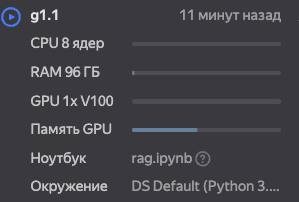
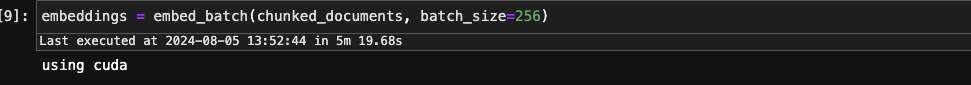

#### Сохранение `embeddings`

In [19]:
# save_name_embeddings = f"../../data/embeddings/USER-bge-m3/embeddings_batched_256"

# torch.save(embeddings.cpu(), f'{save_name_embeddings}.pt')

#### Загрузка `embeddings`

In [20]:
load_name_embeddings = f"../../data/embeddings/USER-bge-m3/embeddings_batched_256"

embeddings_uploaded = torch.load(f'{load_name_embeddings}.pt')

#### FAISS

#### Ниже код с двумя примерами использования эмбеддера, более стабильный вариант - `HuggingFaceEmbeddings`

Код основан на статье [Advanced RAG with Gemma and LangChain](https://www.kaggle.com/code/habibadoum/advanced-rag-with-gemma-and-langchain)

In [239]:
# class Embedder_USER_bge_m3(Embeddings):
    
#     def __init__(self, tokenizer, smodel, batch_size):
#         super().__init__()
#         self.tokenizer = tokenizer
#         self.model = model
#         self.batch_size = batch_size
    
#     def embed(self, input_texts):
#         """
#         Взято с https://huggingface.co/deepvk/USER-bge-m3
#         """
#         batch_size = self.batch_size
#         device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#         print(f"using {device}")

#         model.to(device)
#         model.eval()

#         all_embeddings = []

#         # Разбейте входные тексты на батчи
#         for i in range(0, len(input_texts), batch_size):
#             batch_texts = input_texts[i:i + batch_size]

#             encoded_input = tokenizer(batch_texts, padding=True, truncation=True, return_tensors='pt')
#             encoded_input = {k: v.to(device) for k, v in encoded_input.items()}

#             with torch.no_grad():
#                 model_output = model(**encoded_input)

#             # Perform pooling. In this case, cls pooling.
#             embeddings = model_output[0][:, 0]
#             # Normalize embeddings
#             embeddings = torch.nn.functional.normalize(embeddings, p=2, dim=1)

#             all_embeddings.extend(embeddings.tolist())

#         return all_embeddings

#     def embed_documents(self, documents):
#         return self.embed(documents)
    
#     def embed_query(self, text) -> List[float]:
#         return self.embed([text])
        
# embd = Embedder(tokenizer, model, batch_size=3)

# db = FAISS.from_texts(chunked_documents, embd, distance_strategy=DistanceStrategy.COSINE)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"using {device}")

embedding_model = HuggingFaceEmbeddings(
    model_name="deepvk/USER-bge-m3",
    model_kwargs={'device': device})

using cpu


In [12]:
# db = FAISS.from_texts(chunked_documents, embedding_model, distance_strategy=DistanceStrategy.COSINE)

#### Сохранение `FAISS`

NB: модель сохранена после обучения на gpu, при использовании ВМ с cpu db не загрузится c ошибкой:
`RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.`

In [14]:
# name_db = f"FAISS_GPU_USER-bge-m3_RecursiveCharacter_CHUNK_SIZE_{CHUNK_SIZE}"
# save_path_db = f"../../data/vector_dbs/{name_db}"

# with open(save_path_db, 'wb') as f:
#     pickle.dump(db, f)

#### Сбор FAISS и сохранение db для cpu

In [ ]:
# db_cpu = FAISS.from_texts(chunked_documents, embedding_model, distance_strategy=DistanceStrategy.COSINE)

# name_db = f"FAISS_CPU_USER-bge-m3_RecursiveCharacter_CHUNK_SIZE_{CHUNK_SIZE}"
# save_path_db = f"../../data/vector_dbs/{name_db}"

# with open(save_path_db, 'wb') as f:
#     pickle.dump(db_cpu, f)

#### Загрузка `FAISS` (проверить cpu/gpu)

In [9]:
name_db = f"FAISS_CPU_USER-bge-m3_RecursiveCharacter_CHUNK_SIZE_{CHUNK_SIZE}"
load_path_db = f"../../data/vector_dbs/{name_db}"

with open(load_path_db, 'rb') as f:
    db = pickle.load(f)

#### EnsembleRetriever

In [10]:
retriever = db.as_retriever().configurable_fields(
    search_kwargs=ConfigurableField(
        id="search_kwargs_faiss",
        name="Search Kwargs",
        description="The search kwargs to use",
    )
)

In [11]:
bm25_retriever = BM25Retriever.from_documents(
    chunked_documents_with_page_content
    ).configurable_fields(
    k=ConfigurableField(
        id="search_kwargs_bm25",
        name="k",
        description="The search kwargs to use",
    )
)

In [12]:
# initialize the ensemble retriever
vector_database = EnsembleRetriever(
    retrievers=[bm25_retriever, retriever], weights=[0.5, 0.5] # You can adjust the weight of each retriever in the EnsembleRetriever
)

In [14]:
%%time

#  Пример работы
num_docs = 50

user_query = """
Ипотека
"""
config = {"configurable": {"search_kwargs_faiss": {"k": num_docs}, "search_kwargs_bm25": num_docs}}
retrieved_docs = vector_database.invoke(user_query, config=config)
print("----------------------Top document content----------------------")
print(retrieved_docs[0].page_content)
print("----------------------Top document metadata----------------------")
print(retrieved_docs[0].metadata)

----------------------Top document content----------------------
Федеральный закон Об ипотеке. Статья 6. Право отдавать имущество в залог по договору об ипотеке. 1. Ипотека может быть установлена на указанное в статье 5 настоящего Федерального закона имущество, которое принадлежит залогодателю на праве собственности, а в случаях и в порядке, которые предусмотрены Гражданским кодексом Российской Федерации и другими федеральными законами, - на праве хозяйственного ведения или оперативного управления.2. Не допускается ипотека имущества, изъятого из оборота, имущества, на которое в соответствии с федеральным законом не может быть обращено взыскание, а также имущества, в отношении которого в установленном федеральным законом порядке предусмотрена обязательная приватизация либо приватизация которого запрещена.3. Если предметом ипотеки является имущество, на отчуждение которого требуется согласие или разрешение другого лица или органа, такое же согласие или разрешение необходимо для ипотеки э

## Reranking

- Загружаем модель реранкер
- Ранжируем документы
- Возвращаем `n` релевантных документов

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"using {device}")

using cpu


### `DiTy/cross-encoder-russian-msmarco`

In [ ]:
# reranker_model = CrossEncoder('DiTy/cross-encoder-russian-msmarco', max_length=512, device=device)

#### Сохранение реранкера

In [12]:
# # Укажите путь, куда вы хотите сохранить модель и токенизатор
# save_directory = "../../models/DiTy_cross-encoder-russian-msmarco"

# # Сохраните модель на локальном диске
# reranker_model.save_pretrained(save_directory)

# print(f"Модель сохранена в {save_directory}")

Модель сохранена в ../../models/DiTy_cross-encoder-russian-msmarco


#### Загрузка реранкера локально

In [139]:
path_to_model = "../../models/DiTy_cross-encoder-russian-msmarco"

reranker_dity = CrossEncoder(path_to_model, max_length=512, device=device)

### `xlm-roberta-base`

https://huggingface.co/FacebookAI/xlm-roberta-base

In [140]:
reranker_xlm = CrossEncoder("xlm-roberta-base", max_length=512, device=device)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Определение функции реранка

In [141]:
def get_reranked_docs(query: str, 
                      retrieved_docs: Document, 
                      reranker_model,
                      k: int = 5) -> List:
    
    documents = [doc.page_content for doc in retrieved_docs]
    rank_result = reranker_model.rank(query[0], documents)
    k_documents = [documents[int(doc['corpus_id'])] for doc in rank_result[:k]]
    
    return k_documents

#### Сравнение реранкеров

In [142]:
random_ids = [3657, 2286, 1679, 8935, 1424, 9674, 6912, 520, 488, 1535]

In [143]:
query = "Что будет, если я не оплачу чек?"

In [144]:
chunked_documents_with_page_content[2286]

Document(metadata={'source': '../../data/codex/Гражданский кодекс/Гражданский кодекс_Статья 885.txt'}, page_content='Гражданский кодекс. Статья 885. Последствия неоплаты чека. 1. В случае отказа плательщика от оплаты чека чекодержатель вправе по своему выбору предъявить иск к одному, нескольким или ко всем обязанным по чеку лицам (чекодателю, авалистам, индоссантам), которые несут перед ним солидарную ответственность.2. Чекодержатель вправе потребовать от указанных лиц оплаты суммы чека, своих издержек на получение оплаты, а также процентов в соответствии с пунктом 1 статьи 395 настоящего Кодекса.Такое же право принадлежит обязанному по чеку лицу после того, как оно оплатило чек.3. Иск чекодержателя к лицам, указанным в пункте 1 настоящей статьи, может быть предъявлен в течение шести месяцев со дня окончания срока предъявления чека к платежу. Регрессные требования по искам обязанных лиц друг к другу погашаются с истечением шести месяцев со дня, когда соответствующее обязанное лицо удо

In [145]:
subset_docs_with_page_content = [chunked_documents_with_page_content[i] for i in random_ids]
# subset_docs = [doc.page_content for doc in subset_docs_with_page_content]

In [146]:
for i, doc in enumerate(subset_docs_with_page_content):
    print(i)
    print(doc.page_content[:100])
    print("- - -")

0
о таком земельном участке);документы, удостоверяющие права на землю, а в случае их отсутствия - копи
- - -
1
Гражданский кодекс. Статья 885. Последствия неоплаты чека. 1. В случае отказа плательщика от оплаты
- - -
2
Гражданский кодекс. Статья 405. Просрочка должника. 1. Должник, просрочивший исполнение, отвечает п
- - -
3
члены саморегулируемой организации с указанием причин отказа.Решение об отказе в приеме лица в члены
- - -
4
Гражданский кодекс. Статья 241. Выкуп домашних животных при ненадлежащем обращении с ними. В случая
- - -
5
Федеральный закон О рынке ценных бумаг. Статья 8.2. Счета, открываемые депозитариями и держателями р
- - -
6
Трудовой кодекс. Статья 161. Разработка и утверждение типовых норм труда. Для однородных работ могу
- - -
7
с заявлением об обеспечении иска.7. Определение арбитражного суда об отказе в обеспечении иска может
- - -
8
Арбитражный процессуальный кодекс. Статья 6.1. Разумные сроки судопроизводства в арбитражных судах
- - -
9
Гражданский коде

In [147]:
# reranker_dity

get_reranked_docs(query, subset_docs_with_page_content, reranker_dity, k=3)

['Гражданский кодекс. Статья 321. Исполнение обязательства, в котором участвуют несколько кредиторов или несколько должников. Если в обязательстве участвуют несколько кредиторов или несколько должников, то каждый из кредиторов имеет право требовать исполнения, а каждый из должников обязан исполнить обязательство в равной доле с другими постольку, поскольку из закона, иных правовых актов или условий обязательства не вытекает иное.',
 'Гражданский кодекс. Статья 405. Просрочка должника. 1. Должник, просрочивший исполнение, отвечает перед кредитором за убытки, причиненные просрочкой, и за последствия случайно наступившей во время просрочки невозможности исполнения.2. Если вследствие просрочки должника исполнение утратило интерес для кредитора, он может отказаться от принятия исполнения и требовать возмещения убытков.3. Должник не считается просрочившим, пока обязательство не может быть исполнено вследствие просрочки кредитора.',
 'Трудовой кодекс. Статья 161. Разработка и утверждение т

In [148]:
# reranker_xlm

get_reranked_docs(query, subset_docs_with_page_content, reranker_xlm, k=3)

['Трудовой кодекс. Статья 161. Разработка и утверждение типовых норм труда. Для однородных работ могут разрабатываться и устанавливаться типовые (межотраслевые, отраслевые, профессиональные и иные) нормы труда. Типовые нормы труда разрабатываются и утверждаются в порядке, установленном уполномоченным Правительством Российской Федерации федеральным органом исполнительной власти.',
 'о таком земельном участке);документы, удостоверяющие права на землю, а в случае их отсутствия - копия решения исполнительного органа государственной власти или органа местного самоуправления, предусмотренных статьей\xa039.2 настоящего Кодекса, о предоставлении земельного участка.Исполнительный орган государственной власти или орган местного самоуправления, предусмотренные статьей\xa039.2 настоящего Кодекса, запрашивает указанные документы (их копии, сведения, содержащиеся в них) в государственных органах, органах местного самоуправления и подведомственных государственным органам или органам местного самоупр

In [150]:
query = "Как выкупить домашнее животное"

In [151]:
# reranker_dity

get_reranked_docs(query, subset_docs_with_page_content, reranker_dity, k=3)

['Гражданский кодекс. Статья 405. Просрочка должника. 1. Должник, просрочивший исполнение, отвечает перед кредитором за убытки, причиненные просрочкой, и за последствия случайно наступившей во время просрочки невозможности исполнения.2. Если вследствие просрочки должника исполнение утратило интерес для кредитора, он может отказаться от принятия исполнения и требовать возмещения убытков.3. Должник не считается просрочившим, пока обязательство не может быть исполнено вследствие просрочки кредитора.',
 'Гражданский кодекс. Статья 321. Исполнение обязательства, в котором участвуют несколько кредиторов или несколько должников. Если в обязательстве участвуют несколько кредиторов или несколько должников, то каждый из кредиторов имеет право требовать исполнения, а каждый из должников обязан исполнить обязательство в равной доле с другими постольку, поскольку из закона, иных правовых актов или условий обязательства не вытекает иное.',
 'Трудовой кодекс. Статья 161. Разработка и утверждение т

In [152]:
# reranker_xlm

get_reranked_docs(query, subset_docs_with_page_content, reranker_xlm, k=3)

['Трудовой кодекс. Статья 161. Разработка и утверждение типовых норм труда. Для однородных работ могут разрабатываться и устанавливаться типовые (межотраслевые, отраслевые, профессиональные и иные) нормы труда. Типовые нормы труда разрабатываются и утверждаются в порядке, установленном уполномоченным Правительством Российской Федерации федеральным органом исполнительной власти.',
 'о таком земельном участке);документы, удостоверяющие права на землю, а в случае их отсутствия - копия решения исполнительного органа государственной власти или органа местного самоуправления, предусмотренных статьей\xa039.2 настоящего Кодекса, о предоставлении земельного участка.Исполнительный орган государственной власти или орган местного самоуправления, предусмотренные статьей\xa039.2 настоящего Кодекса, запрашивает указанные документы (их копии, сведения, содержащиеся в них) в государственных органах, органах местного самоуправления и подведомственных государственным органам или органам местного самоупр

## LLM 

- Обращаемся по API к языковой модели
- Возможно, нормализуем ответ 
- Формируем промт с `n` релевантыми документами и запросом пользователя
- Возвращаем ответ модели

## RAG

- Формируем полный пайплан работы RAG-системы (https://python.langchain.com/v0.2/docs/tutorials/rag/#retrieval-and-generation-retrieve)

In [ ]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

for chunk in rag_chain.stream("What is Task Decomposition?"):
    print(chunk, end="", flush=True)